# Solution of the olympic task "Спасти парашютиста" with ***custom gradient descent***

### The description

Парашютист выпрыгнул из самолета, но у него парашют раскрылся неполностью. К счастью рядом оказался спасательный дрон. Для спасения дрону необходимо рассчитать траекторию падающего парашютиста. Координата высоты вычисляема тривиально, однако дрону необходимо вычислить плоскостные координаты $(x, y)$. Есть траектория изменения, по ним необходимо вычислить последующие координаты дрона.
Есть примерная формула изменения координат, она зависит от двух коэффициентов $k_1$ и $k_2$ и случайного шума:

#### $ x = k_2cos(k_1t) + n $,  $ y = k_1sin(k_2t) + n $, где $t$ - № секунды ($1000≤t≤1999$), а $n$ - случайный шум.

На вход подается `list` в $1000$ пар координат ($x, y$) в первую тысячу секунд (с $0$ по $999$-ю).
Пример входных данных:

$ [(0.8990863593574939, 8.475387292276096e-07), (0.8089593833113505, 0.3534820061950688), (0.5566465706027002, 0.4399620826711653), ..., (0.19273411906364982, 0.19411748737324), (-0.20981822525965102, -0.19835273653070376), (-0.5703058016775612, -0.44099688186601116)] $

На выходе программа должна вывести `list` в $1000$ пар координат ($x, y$) во вторую тысячу секунд (с $1000$ по $1999$-ю).
Пример выходных данных:

$ [(0.8990863593574939, 8.475387292276096e-07), (0.8089593833113505, 0.3534820061950688), (0.5566465706027002, 0.4399620826711653), ..., (0.19273411906364982, 0.19411748737324), (-0.20981822525965102, -0.19835273653070376), (-0.5703058016775612, -0.44099688186601116)] $

### ***Referense:*** Taylor's Rows and complex numbers

Let there be a sum: $\sin \alpha + \sin 2\alpha + \sin 3\alpha + \sin 4\alpha + \ldots + \sin n\alpha$, *where n - come natural number, and alpha - some real number*

**Euler's great identity: $e^{\pi i} = -1$**

$e^{i\alpha} = \cos \alpha + i \sin \alpha$

$f(x) \approx f(x_0) + f'(x_0) * (x - x_0) + f''(x_0) * (x-x_0)^2/2! + f'''(x_0) * (x-x_0)^3/3!$ (Taylor's Row)

$\sin x = x - x^3 / 3! + x^5 / 5! - x^7 / 7! + x^9 / 9! - \ldots$ (Taylor's Row for $ f(x) = \sin{x}$ in $0$)

$\cos x = 1 - x^2/2! + x^4/4! - x^6/6! + \ldots$ (Taylor's Row for $ f(x) = \cos{x}$ in $0$)

$e^x = 1 + x + x^2/2! + x^3 / 3! + x^4 / 4! + \ldots$

$ e^{ix} = 1 + ix - \frac{x^2}{2!} - \frac{ix^3}{3!} + \frac{x^4}{4!} + \frac{ix^5}{5!} - \frac{x^6}{6!} - \frac{ix^7}{7!} +  \ldots = \cos x + i\sin x $

$Im(e^{i\alpha} + e^{2i\alpha} + e^{3i\alpha} + \ldots)$, where $Im$ - complex part of the sum

### Import libraries

In [10]:
import torch
from tqdm import tqdm
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


### Solution

In [11]:
def dataloader(k1: float, k2: float, noise_intensity=.01) -> tuple:
    t = torch.tensor([t for t in range(1000)], dtype=torch.float)
    x = k2 * torch.cos(k1 * t) + noise_intensity * torch.randn(1000)
    y = k1 * torch.sin(k2 * t) + noise_intensity * torch.randn(1000)
    return t, torch.stack([x, y], dim=0).requires_grad_(True)

In [12]:
def model(k1k2: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    x = k1k2[1] * torch.cos(k1k2[0] * t)
    y = k1k2[0] * torch.sin(k1k2[1] * t)
    return torch.stack([x, y], dim=0).requires_grad_(True)

In [13]:
def clip_grad(grad: torch.Tensor, max_grad_len: float) -> tuple:
    grad_len = torch.norm(grad)
    if grad_len < max_grad_len:
        return grad, grad_len
    return (grad / grad_len) * max_grad_len, grad_len

In [14]:
def main(alpha=.01, step=1, max_grad_len=1., desired_grad_len=1e-3) -> list:
    t, y = dataloader(3., 5.)
    k1k2 = torch.tensor([1, 1], dtype=torch.float, requires_grad=True)
    grad_len = desired_grad_len + 1
    k1k2_list = []
    i = 0
    while grad_len > desired_grad_len:
        yy = model(k1k2, t)
        mse = ((yy - y)**2).mean()
        mse.backward()
        clipped_grad, grad_len = clip_grad(k1k2.grad, max_grad_len)
        k1k2 = (k1k2 - clipped_grad * alpha * step).clone().detach().requires_grad_(True)
        i += 1
        if i % 10 == 0:
            k1k2_list.append([*k1k2.detach().numpy()])
        if i == 100000:
            break
    return k1k2_list

In [15]:
t, y = dataloader(0.3, 0.5)
t = t.numpy()
y = y[0].detach().numpy()

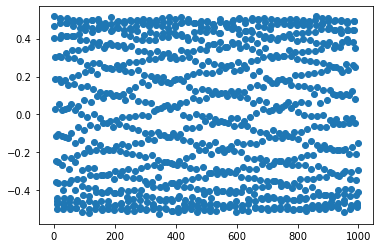

In [16]:
plt.scatter(t, y)

### Main function

In [17]:
k1k2_list = main()

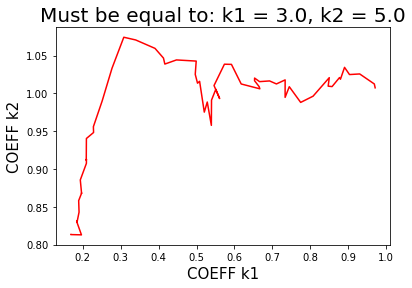

In [22]:
k1_x = [x[0] for x in k1k2_list]
k2_y = [y[1] for y in k1k2_list]

xlabel('COEFF k1', fontsize=15)
ylabel('COEFF k2', fontsize=15)
title('Must be equal to: k1 = 3.0, k2 = 5.0', fontsize=20)
plot(k1_x, k2_y, color='r')